## Background and set up
You are an actuary on the modeling team for an insurance company, tasked with updating the pricing model to predict auto claims for a book of business in Spain. Your coworkers have asked you to review their proposals which make various improvements over the existing model. Follow the instructions in the Jupyter notebook below as we go through a simplified model building process to get a better understanding of the data and help launch an improved model.

Much of the code is provided for you. We will be making use of many common Python packages (see below cell). You should make sure you have these installed on your system before proceeding.

### Tasks:
There are three types of tasks you will be assigned in this notebook. Each task has a point value.

1. **Code completion**: You will be asked to adapt/tweak the provided code to complete a task (e.g. write a single line that creates a new variable in our dataset). While there are many ways to solve these, hints are provided to lead you to the easy solution. Don't overthink these - most can be solved in one or a few lines! Some harder tasks are also included as extra credit and these are often real tasks that analysts perform in their day-to-day work.

2. **Short response**: You will also be provided some relevant guiding questions to be answered in a separate document (e.g. Word document). Some questions will ask you to think critically about general modeling best practices and others might expect you to have minimal domain knowledge of auto insurance. This is not a closed-notes test: you are encouraged to use other resources to help you answer these questions as long as you do not just copy/paste the answer. Remember, the purpose is to learn about real-world tasks. You should have a References section to your document listing out what sources you consulted.

3. **Open-ended analysis**: There are several tasks which are more open-ended. These tasks are intended to let you be creativity shine while investigating a dataset. This is the fun part of modeling! Make your best effort at these tasks and if you are struggling, an LLM may help you debug issues or even provide inspiration. [Kaggle](kaggle.com) is another great way to see how other ML experts are handling tabular datasets across a variety of disciplines. Take a look at the featured notebooks to get fresh ideas on popular packages, data visualizations, and feature engineering.

In [1]:
# import libraries - if you get an error here, you should install the library using pip, conda, or whatever package manager you use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import statsmodels.api as sm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)
# you can add additional packages here if you want them, but this is not required

In [2]:
# import dataset and set date columns
df = pd.read_csv('CaseStudyDataset.csv', sep=',', parse_dates=['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence'], dayfirst=True, low_memory=False)
#print(df.columns)
df.head()

,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Max_policies,Max_products,Lapse,Payment,Premium,Cost_claims_year,N_claims_year,Type_risk,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,has_prior_claim,gender
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,0,4,2,1,0,0,222.52,0.0,0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0,F
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,0,4,2,1,0,0,213.78,0.0,0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0,F
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,0,4,2,1,0,0,214.84,0.0,0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0,F
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,0,4,2,1,0,0,216.99,0.0,0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0,F
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,0,4,2,1,0,1,213.70,0.0,0,1,0,0,2004,80,599,7068.0,0,P,NaN,190,0,M


## Task 1: Data Cleaning and Feature Engineering [11 points]
It is important to take a look at the data and make sure it looks reasonable before using it for analysis. If we find anomalies, we should take steps to identify why they occur and fix them where possible. The process of making adjustments to the data to account for known errors is known as "data cleaning".

A related step is to construct useful features from existing features. As an example, we can calculate the age of a driver by taking the difference between the `'Date_start_constract'` and `'Date_birth'`. This is done for you in the cell below.

In the cells below, you should follow the instructions to create new engineered features or fix the problems associated with existing variables:
- `'age'`: calculate age based on `'Date_start_constract'` and `'Date_birth'` (this code is already provided)
- `'driving_experience'`: similarly to age, calculate number of years of driving experience, based on `'Date_start_constract'` and `'Date_driving_licence'` **[1 point]**
- `'driving_experience'` part 2: there may be some records with a negative value for `'driving_experience'`, which does not make sense. Set these to zero using the `.clip(...)` function in pandas. It may be helpful to reference the pandas documentation. **[1 point]**
- `'Seniority`: this represents how long the insured has been with the company. We would expect that $0 <= \text{Seniority} < \text{age}$. If this is not the case, set `'Seniority'` to 0. There are many ways to accomplish this, but if you need a hint, you may refer to the numpy documentation on how to use the `np.where(...)` function. **[1 point]**
- `'Distribution_channel'`: first, we convert `'distribution_channel'` to an integer if possible (this step is provided for you). There may be some records with a missing `'Distribution_channel'`. Impute these missing values with the most common value. Hint: the `.fillna(...)` method of pandas may be helpful here. **[1 point]**
- `'Cost_claims_year'` is our target variable, representing the total loss for the policy. Some of these values are missing, so we will remove them from our dataset. **[1 point]**

There are many other ways to handle missing values. In addition to replacing missing values with the most frequent value, suggest two alternative methods. Compare and contrast the tradeoffs associated with each method. **[6 points]**

In [3]:
# calculate the age of the insured person
df['age'] = df['Date_start_contract'].dt.year - df['Date_birth'].dt.year
# TODO: calculate the number of years of driving experience the insured has
df['driving_experience'] = df['Date_start_contract'].dt.year - df['Date_driving_licence'].dt.year

In [4]:
# TODO: there may be some records with driving_experience < 0, which is not possible. Set these to 0.
# df['driving_experience'] = 
df['driving_experience'] = df['driving_experience'].clip(lower=0)

In [5]:
# Seniority represents how long the insured has been with the company. We would expect that 0 <= Seniority < age. If not, set Seniority to 0.
# df['Seniority'] =
df['Seniority'] = np.where((df['Seniority'] < 0) | (df['Seniority'] >= df['age']), 0, df['Seniority'])

In [6]:
def convert_to_int(value):
    'Convert a value to an integer if possible, otherwise return NaN.'
    try:
        return int(value)
    except ValueError:
        return np.nan

df['Distribution_channel'] = df['Distribution_channel'].apply(convert_to_int)
# TODO: there may be some records with a missing Distribution_channel. Set these to the most common value.
# df['Distribution_channel'] =
df['Distribution_channel'] = df['Distribution_channel'].fillna(df['Distribution_channel'].mode()[0])

In [7]:
# TODO: Some loss values (in 'Cost_claims_year') are missing. Remove these records since we cannot use them for training.
# df = 
df = df.dropna(subset=['Cost_claims_year'])

## Task 2: One-way analysis [6 points]

The function below groups the data by a given segment and calculates three values:
- **Frequency**: the proportion of policies which had a loss in a policy term. Can be written as $\text{P}(\text{Loss} > 0)$
- **Severity**: given a loss occurred, this is the mean size of the loss. Can be written as $\text{E}[\text{Loss} | \text{Loss} > 0]$
- **Pure premium**: this is the expectation of loss, which can be written as $\text{E}[\text{Loss}] = \text{E}[\text{Loss} | \text{Loss} > 0] \times \text{P}(\text{Loss} > 0) = \text{frequency} \times \text{severity}$

Example usage: `calculate_freq_sev(df, 'Payment')`

Use the `calculate_freq_sev` function to examine the frequency, severity, and expected loss for each of the following segments:
- `'gender'`
- `'age'`
- `'Distribution_channel'`

For each of the segments above, provide the table with the results. Explain which groups have a higher/lower loss propensity. **[1 point each]**

Explain why the differences in the groups above may or may not reflect the true difference in risk using specific examples. Consider the magnitude of the difference, the size of the dataset (credibility), and whether an intuitive causal relationship may exist in the real world. You are free to run additional queries on this dataset and conduct additional research. **[3 points]**


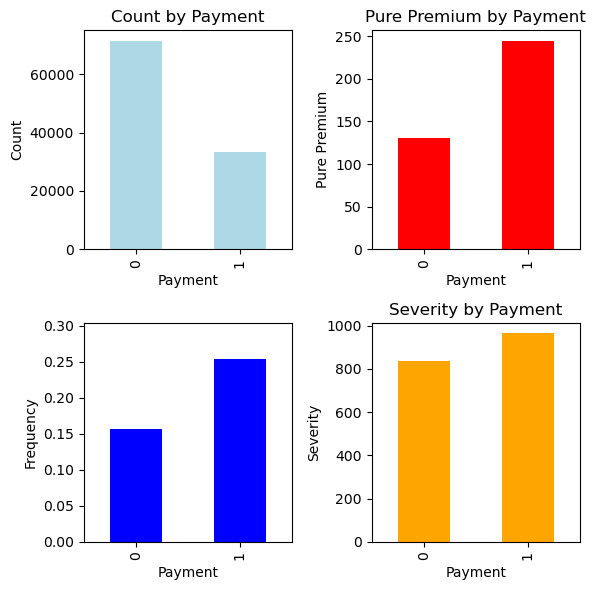

,Payment,count,frequency,pure_premium,severity
0,0,71434,0.156102,130.434986,835.574637
1,1,33508,0.253522,244.479406,964.333837


In [8]:
# calculate the frequency and severity based on Cost_claims_year and N_claims_year by specified column
def calculate_freq_sev(df, col, plot=False):
    '''
    Calculate frequency and severity based on the specified column.
    Parameters:
    df (DataFrame): The input DataFrame containing claims data.
    col (str): The column name to group by.
    plot (bool): Whether to plot the results. Default is False. Note: plot will not display well with too many unique values in `col`.
    Returns:
    DataFrame: A DataFrame containing the row counts, frequency, pure premium, and severity by the specified column.
    '''
    df = df.copy()
    df['count'] = 1
    grouped_df = df.groupby(col).agg({'count': 'sum', 'N_claims_year': 'mean', 'Cost_claims_year': 'mean'}).reset_index()
    grouped_df = grouped_df.rename(columns={'N_claims_year': 'frequency', 'Cost_claims_year': 'pure_premium'})
    grouped_df['severity'] = (grouped_df['pure_premium'] / grouped_df['frequency']).fillna(0)
    if plot:
        fig, ax = plt.subplots(2, 2, figsize=(6, 6))
        ax[0, 0].set_title(f'Count by {col}')
        ax[0, 0].set_ylabel('Count')
        grouped_df.plot(x=col, y='count', kind='bar', ax=ax[0, 0], color='lightblue', legend=False)
        ax[0, 1].set_title(f'Pure Premium by {col}')
        ax[0, 1].set_ylabel('Pure Premium')
        grouped_df.plot(x=col, y='pure_premium', kind='bar', ax=ax[0, 1], color='red', legend=False)
        ax[1, 0].set_ylabel('Frequency')
        ax[1, 0].set_ylim(0, grouped_df['frequency'].max() * 1.2)
        grouped_df.plot(x=col, y='frequency', kind='bar', ax=ax[1, 0], color='blue', legend=False)
        ax[1, 1].set_title(f'Severity by {col}')
        ax[1, 1].set_ylabel('Severity')
        grouped_df.plot(x=col, y='severity', kind='bar', ax=ax[1, 1], color='orange', legend=False)
        plt.tight_layout()
        plt.show()
    return grouped_df
display(calculate_freq_sev(df, 'Payment', True))

In [9]:
# TODO: calculate frequency and severity across age, gender, and distribution channel
display(calculate_freq_sev(df, 'age').head(10))
display(calculate_freq_sev(df, 'gender'))
display(calculate_freq_sev(df, 'Distribution_channel'))

,age,count,frequency,pure_premium,severity
0,18,147,0.163265,86.362332,528.969285
1,19,399,0.157895,139.928063,886.211065
2,20,546,0.194139,180.043829,927.395574
3,21,659,0.177542,150.615130,848.336502
4,22,831,0.173285,299.450086,1728.076538
5,23,975,0.188718,166.603153,882.815619
6,24,1132,0.187279,225.565748,1204.435977
7,25,1304,0.193252,430.132262,2225.763767
8,26,1734,0.188005,220.127642,1170.862979
9,27,2085,0.211031,249.737863,1183.416920


,gender,count,frequency,pure_premium,severity
0,F,52353,0.187325,163.404163,872.305309
1,M,52589,0.187092,170.279156,910.134216


,Distribution_channel,count,frequency,pure_premium,severity
0,0.0,57541,0.173355,146.652581,845.968539
1,1.0,47401,0.204025,191.366691,937.956007


## Task 3: Feature Engineering [2 points]
We saw in the previous task that it was a bit hard to understand patterns across the age column. It may help to do additional feature engineering here. We will add the `'age_grouped'` column to group ages in groups of 5 (with 18-25, 26-30, 31-35, ..., 66+). This may make patterns more obvious.

Redo the age analysis you did earlier using `'age_grouped'` instead. Are there clear patterns this time once we've gotten rid of some of the noise? **[1 point]**

Insurers often group ages together and treat the characteristic as a categorical variable (with dummies) in a generalized linear model as opposed to using it as a linear predictor. Explain why using age as a linear predictor directly may not work well within a GLM. You may use the [GLM for Insurance Rating](https://www.casact.org/sites/default/files/2021-01/05-Goldburd-Khare-Tevet.pdf) as a reference. **[1 point]**


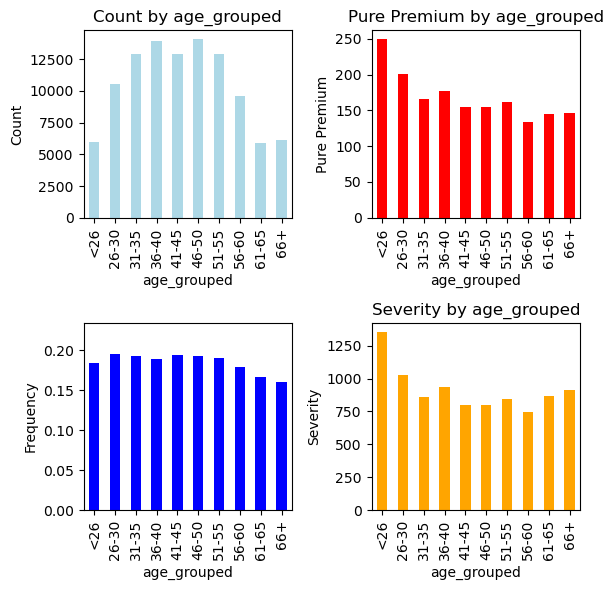

,age_grouped,count,frequency,pure_premium,severity
0,<26,5993,0.183881,249.224070,1355.353769
1,26-30,10534,0.195178,200.052428,1024.976790
2,31-35,12946,0.193264,166.475924,861.389815
3,36-40,13979,0.188783,176.979458,937.474743
4,41-45,12923,0.193918,155.213964,800.411035
5,46-50,14078,0.192783,154.322252,800.496927
6,51-55,12901,0.190373,161.043720,845.938532
7,56-60,9600,0.178437,133.589303,748.661592
8,61-65,5874,0.166837,144.392127,865.468728
9,66+,6114,0.159961,146.016194,912.825166


In [10]:
df['age_grouped'] = pd.cut(df['age'], bins=[0, 25, 30, 35, 40, 45, 50, 55, 60, 65, np.inf], labels=['<26', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66+'])
calculate_freq_sev(df, 'age_grouped', True)

## Task 4: Statistical Tests [5 points]

In addition to looking at averages in your data, it is also valuable to use statistical tests to measure feature significance before adding variables to models.

A coworker suggests using the student t-test to determine whether it is valuable to include the `'Type_risk'` variable. Explain in detail why this test should not be used for the `'Type_risk'` variable. Hint: think about the assumptions that the t-test makes. **[1 point]**

After discussing with your team, you propose using the Kruskal-Wallis test instead. Explain why the Kruskal-Wallis test resolves the issues you described in the previous question. **[1 point]**

Use the `kruskal` function from the `scipy.stats` library to test the significance of the `'Type_risk'` variable against pure premium at the $\alpha = 0.05$ significance level. **[1 point]**

Share and interpret the results of the function above: does the `'Type_risk'` variable seem predictive? **[1 point]**

Feature selection in model building is generally a subjective process and often requires a modeler to take into account domain knowledge and business constraints. Assuming that the `'Type_risk'` variable was predictive, provide two reasons for why a modeler may still choose to not include the `'Type_risk'` variable in the final pricing model that they submit to regulators. (You are not expected to run additional queries on the dataset to answer this question.) **[1 point]**

In [11]:
# TODO: use the kruskal test to check if the cost of claims is significantly different between the types of risk.
kruskal(df[df['Type_risk'] == 1]['Cost_claims_year'],
        df[df['Type_risk'] == 2]['Cost_claims_year'],
        df[df['Type_risk'] == 3]['Cost_claims_year'],
        df[df['Type_risk'] == 4]['Cost_claims_year'])

KruskalResult(statistic=1078.194241852514, pvalue=1.9578795781532977e-233)

In [12]:
# set categorical variables
df['gender'] = df['gender'].astype('category')

## Task 5: Train Test Split and One Hot Encoding [3 points]
When building models, it is a best practice to have a train and test dataset. The model will be built on a "train" dataset and then we will evaluate the performance of the model on the "test" (holdout) dataset. This check can help prevent overfitting, which occurs when a model's predictions are very accurate when evaluated against data it has already seen, even though it may not be able to predict future data as accurately as historical data.

In the cell below, we use sklearn's `train_test_split(...)` function to split the dataset into a train and test dataset at an 80/20 split (80% of records will randomly be assigned to the train dataset and the other 20% will be in the test dataset). This is also a good time to specify our taget variable, which is `'Cost_claims_year'` (the expected loss we are trying to predict).

Describe at least one consideration in choosing what proportion of data should go to the train vs test dataset. What are the tradeoffs? **[1 point]**

A common issue that comes up when modeling is being able to identify data leakage. Data leakage refers to the case where relevant information from data in the holdout dataset is inadvertently present in the training dataset. One example is temporal data leakage: if we are building a model on multiple years of data, a randomized train test split like the one above may place a record from Policyholder A's 2018 term in the train dataset and Policyholder A's 2017 term into the holdout dataset. In that case, having information from Policyholder A's 2018 term may help us predict Policyholder A's risk in the prior term. This information is NOT going to be available when the model goes live into production and therefore when we evaluate the model on the holdout dataset, it may appear better than it really is.

Describe one solution to resolving the temporal data leakage issue mentioned above. You are encouraged to use other resources. **[1 point]**

Explain the purpose of the `random_state` parameter in the train_test_split function. **[1 point]**

If possible, implement your solution to the temporal data leakage in Python. You may use the help of an LLM. Be sure to disclose any help you receive. **[Optional, 3 points extra credit]**

Before we move on, let's call attention to the `pd.get_dummies(...)` function. This is necessary to [one-hot encode](https://www.geeksforgeeks.org/machine-learning/ml-one-hot-encoding/) categorical variables so that they can be modeled with a GLM as a numerical field. We do this on the `'Type_risk'`, `'gender'`, and `'age_grouped'` columns. This is generally not required for lightgbm's gradient boosting models since lightgbm can automatically handle specified categorical variables, so we'll hold onto both the df_dummy (new) and df dataframes (original).

For the GLM, we usually take the log of dollar amounts due to the use of a log-link. For more information, see [GLM for Insurance Rating](https://www.casact.org/sites/default/files/2021-01/05-Goldburd-Khare-Tevet.pdf). Note that GBMs do not require this transformation

In [13]:
df['log_Premium'] = np.log(df['Premium'] + 1)  # Adding 1 to avoid log(0)
df['log_Value_vehicle'] = np.log(df['Value_vehicle'] + 1)  # Adding 1 to avoid log(0)

In [14]:
y = df['Cost_claims_year'] # this is the target variable
# we split the dataset into training and testing sets

# df with dummies, for use in the GLM:
df_dummy = pd.get_dummies(df, columns=['gender', 'Type_risk', 'age_grouped'], drop_first=True)

X_glm_train, X_glm_test, y_train, y_test = train_test_split(df_dummy.drop(columns=['Cost_claims_year']), y, test_size=0.2, random_state=42)

X_gbm_train, X_gbm_test, y_train, y_test = train_test_split(df.drop(columns=['Cost_claims_year']), y, test_size=0.2, random_state=42)



## Task 6: Interpreting a GLM [2 points]

The following cell sets up the GLM with a handful of features that seem like they might be important. We use a log link function with the Tweedie family since insurance pure premiums often follow a Tweedie distribution. The variance parameter is usually to be somewhere in between 1 and 2.

Take a look at the model summary for the GLM. Which variables are statistically significant at the $\alpha=0.05$ level? List at least 5 which you find interesting. **[1 point]**

Which variables are not statistically significant? Is this surprising to you? **[1 point]**

In [15]:
features_for_model = ['Distribution_channel', 'Seniority', 'Max_products', 'Payment', 'log_Premium', 'has_prior_claim', 'Area', 'Second_driver', 'driving_experience', 'log_Value_vehicle'] + [col for col in df_dummy.columns if col.startswith('Type_risk_') or col.startswith('age_grouped_') or col.startswith('gender_')]

X_glm_train = sm.add_constant(X_glm_train[features_for_model])  # add a constant term for the intercept

glm_model = sm.GLM(y_train, X_glm_train, family=sm.families.Tweedie(var_power=1.8, link=sm.families.links.log())).fit()

display(glm_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       Cost_claims_year   No. Observations:                83953
Model:                            GLM   Df Residuals:                    83929
Model Family:                 Tweedie   Df Model:                           23
Link Function:                    log   Scale:                          118.34
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 15 Jun 2025   Deviance:                   2.1429e+06
Time:                        22:26:03   Pearson chi2:                 9.93e+06
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.0095      0.521     -5.778      0.000      -4.030      -1.989
Distribution_channel     0.0925      0.049      1.906      0.057      -0.003       0.188
Seniority               -0.0213      0.004     -4.986      0.000      -0.030      -0.013
Max_products             0.0890      0.094      0.949      0.342      -0.095       0.273
Payment                  0.3591      0.051      7.032      0.000       0.259       0.459
log_Premium              0.6383      0.073      8.718      0.000       0.495       0.782
has_prior_claim          0.4980      0.048     10.304      0.000       0.403       0.593
Area                     0.1339      0.052      2.579      0.010       0.032       0.236
Second_driver            0.2467      0.071      3.484      0.000       0.108       0.385
driving_experience      -0.0121      0.004     -3.130      0.002      -0.020      -0.005
log_Value_vehicle        0.4321      0.061      7.141      0.000       0.314       0.551
gender_M                -0.0044      0.046     -0.096      0.924      -0.095       0.086
Type_risk_2              0.1689      0.154      1.097      0.273      -0.133       0.471
Type_risk_3              0.0068      0.141      0.048      0.962      -0.271       0.284
Type_risk_4            -43.8931      0.431   -101.908      0.000     -44.737     -43.049
age_grouped_26-30       -0.0632      0.119     -0.533      0.594      -0.296       0.169
age_grouped_31-35       -0.1795      0.119     -1.503      0.133      -0.414       0.055
age_grouped_36-40       -0.1664      0.123     -1.350      0.177      -0.408       0.075
age_grouped_41-45       -0.0662      0.132     -0.504      0.615      -0.324       0.192
age_grouped_46-50       -0.1004      0.140     -0.718      0.473      -0.375       0.174
age_grouped_51-55       -0.0010      0.152     -0.007      0.995      -0.298       0.296
age_grouped_56-60       -0.0136      0.167     -0.081      0.935      -0.342       0.314
age_grouped_61-65        0.1078      0.188      0.573      0.567      -0.261       0.477
age_grouped_66+          0.2442      0.201      1.215      0.224      -0.150       0.638
========================================================================================
"""

In [16]:
# view the RMSE for the model:
glm_pred = glm_model.predict(sm.add_constant(X_glm_test[features_for_model]))
mse = mean_squared_error(y_test, glm_pred)
print(f'RMSE: {mse**0.5:.2f}')

RMSE: 2111.42


## Task 7: Gradient Boosting Model with lightgbm [2 points]
The next cell sets up a gradient boosting model using lightgbm. For an introduction on gradient boosting models, see these helpful references:
- [Datacamp Guide to GBMs](https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm)
- [Balancing robust statistics and data mining in ratemaking: Gradient Boosting Modeling](https://www.casact.org/sites/default/files/presentation/rpm_2012_handouts_session_4736_presentation_895_0.pdf) for an actuarial perspective on the value of gradient boosting models.

Additionally, take some time to review the documentation of lightgbm's parameters [here](https://lightgbm.readthedocs.io/en/stable/Parameters.html).

We set the list of parameters in the `features_for_model` variable. `X` represents our feature dataset.

We also need to set the parameters of the gradient boosting machine. To highlight a few:
- `'objective'`: this is set to `'regression'` since we are predicting a continuous variable.
- `'metric'`: this is set to `'rmse'`, which tells the optimizer that this is the metric we are trying to minimize
- `'learning_rate'`: this determines how "quickly" the GBM learns from prior trees.

We are using regression and RMSE as the objective and metric for our loss prediction task, since it  is a continuous variable. What would be an appropriate objective and metric if we wanted to predict frequency instead (either a record has at least one loss or it does not)? Hint: think about what the target variable's distribution looks like and refer to the lightgbm documentation above. **[1 point]**

Referring to the documentation above, explain what the `'num_iterations'` parameter does. How might the runtime and RMSE change as we increase the number of iterations? **[1 point]**

In [ ]:
features_for_model = ['Distribution_channel', 'Seniority', 'Max_products', 'Payment', 'Premium', 'Type_risk', 'Area', 'Second_driver', 'has_prior_claim', 'gender', 'age', 'driving_experience', 'Value_vehicle']


# set up LightGBM dataset and parameters
lgb_train = lgb.Dataset(X_gbm_train[features_for_model], y_train)

# set up the parameters for the gradient boosting machine
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'learning_rate': 0.01,
    'num_iterations': 1000,
    'verbose': -1,
}

# Train the model
lgb_model = lgb.train(params, lgb_train)

c:\Users\dlmre\Anaconda3\envs\firstenv\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## Task 8: Model Evaluation [3 points]
In the next cell, we look at the model performance on the holdout dataset and examine feature importances.

Compare the RMSE of the GLM model and the GBM model. Do the results surprise you? **[1 point]**

Describe when a GLM might outperform a GBM and vice-versa. **[1 point]**

Describe some other considerations for an insurance modeler when considering which of the two types of models to use for a production model. There is a lot more actuarial literature and articles on GBMs in recent years, so feel free to do additional research.
 **[1 point]**

RMSE: 2136.00


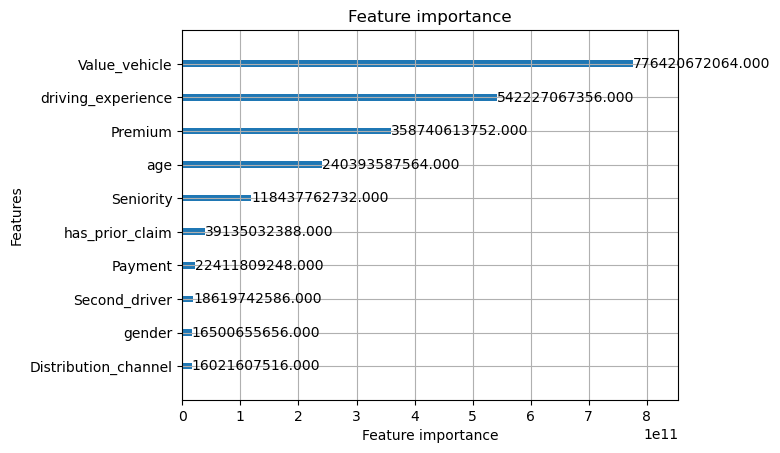

In [20]:
# Predict on the test set
gbm_pred = lgb_model.predict(X_gbm_test[features_for_model], num_iteration=lgb_model.best_iteration)
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, gbm_pred))
print(f'RMSE: {rmse:.2f}')
# Feature importance
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain')
plt.title('Feature importance')
plt.show()

## Task 9: Improve the models [12 points]

Now that we've built and run both a GBM and GLM, it's your turn to try to improve them! Based on analysis we've done in earlier steps, consider adding additional fields into the models and see which ones improve the RMSE the most on the holdout dataset. You are free to perform any data cleaning you'd like. You may also explore adding interactions between variables for the GLM. The expectation is you'll try out at least three new variables in each of the models. You should provide your complete code in this notebook. Include feature engineering, any EDA you've performed, and the impact on the RMSE (for better or worse). For each of the new variables, comment on the results - is there a causal relationship between the variable and pure premium? **[12 points]**

For each variable, points are awarded for:
- evidence of initial EDA (one way analysis, plotting, distribution statistics, etc)
- feature engineering code, if any
- running a GLM or GBM model with the new variable and sharing the resulting RMSE
- comments on the result - did the model improve? Why or why not?

You may experiment with more than three variables. You can also experiment with the hyperparameters of the two models: you can tweak the learning rate, num iterations, etc of the GBM and you can tweak the Tweedie power in the GLM. Extra credit may be awarded for creativity, improving the RMSE, and/or thoughtful analysis of results.